In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import datetime
import numpy as np

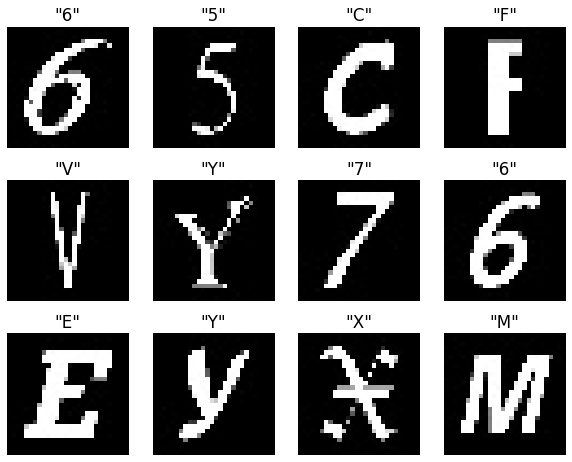

In [2]:
dataset_paths = glob.glob("dataset_characters/**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))
# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

plt.savefig("Visualize_dataset.jpg",dpi=300)  

In [ ]:
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))

In [ ]:
# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes_AlexNet.npy', lb.classes_)

In [ ]:
#Train the model by splitting the test in ratio of 0.10
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

In [ ]:
#Define The Image Shape
img_shape = (80, 80 , 3)

l2_reg = 0

#Create a model for Training and Testing, AlexNet
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):   
    # Initialize model
    model = Sequential()

    # 1st Conv Layer 
    model.add(Conv2D(96, (11, 11), input_shape=img_shape, padding='same', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 2nd Conv Layer 
    model.add(Conv2D(256, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 3rd Conv Layer 
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 4th Conv Layer 
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(1024, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # 5th Conv Layer 
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(1024, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 1st FC Layer
    model.add(Flatten())
    model.add(Dense(3072))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # 2nd FC Layer
    model.add(Dense(4096))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    # 3rd FC Layer
    model.add(Dense(output_shape))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
   
    
    if training:
        # compile model
        optimizer = Adadelta()
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 30

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

print(model.summary())

BATCH_SIZE = 64

log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'Alex_Net'

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint(filepath="License_character_recognition_Alex_Net.h5", verbose=1, save_weights_only=True, restore_best_weights = True),
                TensorBoard(log_dir=log_dir, histogram_freq=1)
                ]

result = model.fit(trainX, trainY, batch_size=BATCH_SIZE, 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer, shuffle=True)

# save model architectur as json file
model_json = model.to_json()
with open("MobileNets_character_recognition_Alex_Net.json", "w") as json_file:
  json_file.write(model_json)